In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt

figsize = (12,8)
pktPayloadSize = 1462 # Bytes

In [2]:
def removekey(d, key):
    r = dict(d)
    del r[key]
    return r

In [3]:
msgStartEntryDict = {}
msgCompletionTimesDict = {}

with open("MsgTraces.tr",'r') as f:
    for line in f:
        msgLog = line.split()
        
        time = float(msgLog[1])*1e-9        # in seconds
        msgSize = int(msgLog[2])#//1462*1462 # in bytes
        sender = msgLog[3]                  # ip:port
        receiver = msgLog[4]                # ip:port
        txMsgId = int(msgLog[5])
        
        key = (sender, receiver, txMsgId)
        
        if (msgLog[0]=='+'):
            if (key in msgStartEntryDict):
                msgStartEntryDict[key].append(time)
            else:
                msgStartEntryDict[key] = [time]
                
        elif (msgLog[0] =='-'):
            if (key in msgStartEntryDict):
                startTime = msgStartEntryDict[key].pop()
                if (len(msgStartEntryDict[key]) <= 0):
                    msgStartEntryDict = removekey(msgStartEntryDict, key)
                    
                if (msgSize in msgCompletionTimesDict):
                    msgCompletionTimesDict[msgSize].append(time-startTime)
                else:
                    msgCompletionTimesDict[msgSize] = [time-startTime]
            else:
                print('ERROR: Start entry of message (' \
                      + sender + ' > ' + receiver + ', ' + str(txMsgId) \
                      + ') not found!')

In [4]:
i = 0
for msgKey, msgStartTimes in msgStartEntryDict.items():
    print(msgKey, ' : ', msgStartTimes)
    i += len(msgStartTimes)
print ('Number of uncompleted messages: ' + str(i))

('10.0.36.1:1036', '10.0.85.1:1085', 0)  :  [3.00044483]
('10.0.62.1:1062', '10.0.106.1:1106', 1)  :  [3.003333918]
('10.0.100.1:1100', '10.0.19.1:1019', 0)  :  [3.001801473]
('10.0.1.1:1001', '10.0.6.1:1006', 0)  :  [3.0005056270000003]
('10.0.86.1:1086', '10.0.1.1:1001', 1)  :  [3.0040923900000003]
('10.0.140.1:1140', '10.0.95.1:1095', 2)  :  [3.001284343]
('10.0.124.1:1124', '10.0.106.1:1106', 1)  :  [3.004207955]
('10.0.140.1:1140', '10.0.96.1:1096', 1)  :  [3.000471907]
('10.0.5.1:1005', '10.0.127.1:1127', 0)  :  [3.000415717]
('10.0.60.1:1060', '10.0.88.1:1088', 2)  :  [3.0031340330000003]
Number of uncompleted messages: 10


In [5]:
print (json.dumps(msgCompletionTimesDict, sort_keys=True, indent=4))

{
    "1462": [
        2.901999999860294e-06,
        4.011000000136988e-06,
        2.901999999860294e-06,
        2.901999999860294e-06
    ],
    "2924": [
        5.202999999731617e-06,
        5.203000000175706e-06
    ],
    "4386": [
        6.4640000001503495e-06,
        6.516000000011957e-06,
        6.468000000037222e-06,
        5.303999999650699e-06,
        6.586000000030623e-06,
        8.769999999991285e-06
    ],
    "5848": [
        7.802999999917404e-06,
        7.6050000004102e-06,
        1.007299999988831e-05,
        7.604999999966111e-06
    ],
    "7310": [
        8.805999999861314e-06,
        1.086299999997209e-05,
        8.951999999951e-06,
        8.806000000305403e-06
    ],
    "8772": [
        1.0351999999880235e-05,
        1.0006999999756516e-05,
        1.016999999992052e-05
    ],
    "10234": [
        1.1208000000095808e-05
    ],
    "11696": [
        1.260099999988995e-05
    ],
    "13158": [
        1.3897999999734623e-05,
        1.36100

In [6]:
print('Number of distinct message sizes: ' + str(len(msgCompletionTimesDict)))

cntMultMeasures = 0
numMsgs = 0
nonFullPacketMsgSizes = []
for msgSize, msgCompletionTimes in msgCompletionTimesDict.items():
    
    if (len(msgCompletionTimes)>1):
        cntMultMeasures += 1
    
    numMsgs += len(msgCompletionTimes)
    
    if (msgSize%pktPayloadSize != 0):
        nonFullPacketMsgSizes.append((msgSize,msgSize%pktPayloadSize))
    
print('Number of distinct message sizes that '\
      +'have multiple measurements: ' + str(cntMultMeasures))   
print('Number of distinct messages: ' + str(numMsgs)) 

if (nonFullPacketMsgSizes):
    print('Non-Full Packet Message Sizes: ', nonFullPacketMsgSizes)

Number of distinct message sizes: 89
Number of distinct message sizes that have multiple measurements: 26
Number of distinct messages: 135
Non-Full Packet Message Sizes:  [(4653618, 72), (3630218, 72), (14621606, 144), (15595208, 54), (3703282, 36), (1827572, 72)]


In [7]:
msgSizes = []
p50CompletionTimes = []
p99CompletionTimes = []
baseCompletionTimes = []
p50SlowDowns = []
p99SlowDowns = []

for msgSize, msgCompletionTimes in msgCompletionTimesDict.items():
    
    msgSizes.append(msgSize)
    
    times = np.array(msgCompletionTimes)
    p50CompletionTime = np.percentile(times,50)
    p50CompletionTimes.append(p50CompletionTime)
    p99CompletionTime = np.percentile(times,99)
    p99CompletionTimes.append(p99CompletionTime)
    
    baseCompletionTime = (msgSize+pktPayloadSize)*8.0/10e9 + 0.5e-6
    baseCompletionTimes.append(baseCompletionTime)
    
    p50SlowDowns.append(p50CompletionTime / baseCompletionTime)
    p99SlowDowns.append(p99CompletionTime / baseCompletionTime)
    
zipData = sorted(zip(msgSizes,
                     p50CompletionTimes,
                     p99CompletionTimes,
                     baseCompletionTimes,
                     p50SlowDowns,
                     p99SlowDowns))
    
msgSizes = np.array([x for x,_,_,_,_,_ in zipData])
p50CompletionTimes = np.array([x for _,x,_,_,_,_ in zipData])
p99CompletionTimes = np.array([x for _,_,x,_,_,_ in zipData])
baseCompletionTimes = np.array([x for _,_,_,x,_,_ in zipData])
p50SlowDowns = np.array([x for _,_,_,_,x,_ in zipData])
p99SlowDowns = np.array([x for _,_,_,_,_,x in zipData])

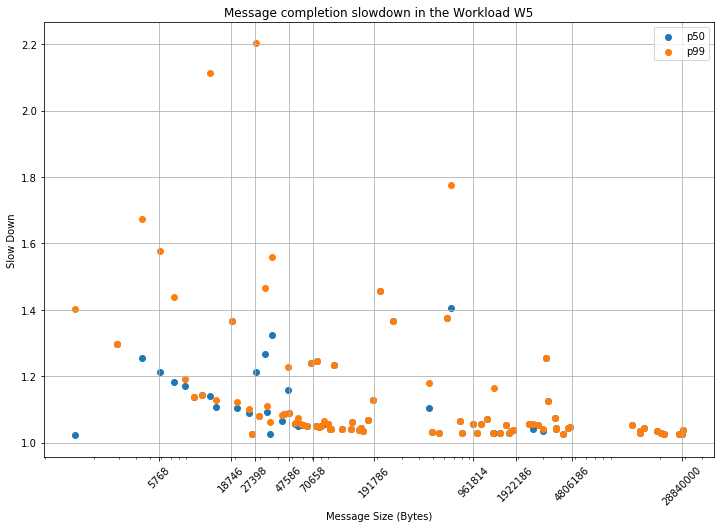

In [8]:
plt.figure(figsize=figsize)
plt.grid()
plt.scatter(msgSizes,p50SlowDowns,label='p50')
plt.scatter(msgSizes,p99SlowDowns,label='p99')
plt.ylabel('Slow Down')
plt.xlabel('Message Size (Bytes)')
plt.title('Message completion slowdown in the Workload W5')
plt.legend()
# plt.ylim([0,10])
plt.xscale('log')
xticks = [5768,18746,27398,47586,70658,191786,961814,1922186,4806186,28840000]
plt.xticks(xticks, xticks, rotation=45)
plt.show()